In this notebook, we build upon findings of the `xgboost` model in `classification_models.ipynb`

In [1]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedKFold
from sklearn.metrics import f1_score, accuracy_score, log_loss, confusion_matrix, classification_report

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
from pathlib import Path

src_path = Path("..", "src")
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from feature_engineering import add_vwap, add_atr, add_ema, add_dow, add_return, add_jump_categories_3, add_jump_categories_5

We will do all the data cleaning / feature engineering and `xgboost` specific preprocessing as seen in the aforementioned notebook

In [11]:
df_raw = pd.read_csv("./../input/ETHUSDT_1h_2020_2024_join_final.csv")

df_raw.drop(df_raw.columns[df_raw.columns.str.contains('unnamed', case=False)], axis=1, inplace=True)

print(df_raw.info())

df_raw.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43817 entries, 0 to 43816
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      43817 non-null  float64
 1   open                      43817 non-null  float64
 2   high                      43817 non-null  float64
 3   low                       43817 non-null  float64
 4   close                     43817 non-null  float64
 5   volume                    43817 non-null  float64
 6   base_asset_volume         43817 non-null  float64
 7   no_trades                 43817 non-null  int64  
 8   taker_buy_vol             43817 non-null  float64
 9   taker_buy_base_asset_vol  43817 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 3.3 MB
None


,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol
0,1.577840e+12,129.16,129.19,128.68,128.87,7769.17336,1.000930e+06,2504,4149.93345,534619.3390
1,1.577840e+12,128.87,130.65,128.78,130.64,11344.65516,1.474278e+06,4885,5930.54276,770486.0567
2,1.577840e+12,130.63,130.98,130.35,130.85,7603.35623,9.940256e+05,3046,3324.35218,434675.4447
3,1.577850e+12,130.85,130.89,129.94,130.20,4968.55433,6.473610e+05,2818,1810.03564,235890.3302
4,1.577850e+12,130.21,130.74,130.15,130.20,3397.90747,4.430067e+05,2264,1839.74371,239848.3483


In [35]:
# general data cleaning
df = df_raw.copy()

df = add_return(df)

# add jump feature and target variable
df = add_jump_categories_3(df, margin=0.008)
df['next_jump'] = df['jump'].shift(-1)

# feature engineering
df = add_atr(df)
df = add_ema(df)
df = add_vwap(df)

df = add_dow(df)
df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow', drop_first=True)
df = df.dropna()

# lag features
lag_factor = 5
cols = ['open', 'high', 'low', 'close', 'volume', 'atr', 'ema', 'VWAP']

for lag in range(1, lag_factor+1):
    for col in cols:
        newcol = np.zeros(df.shape[0]) * np.nan
        newcol[lag:] = df[col].values[:-lag]
        df.insert(len(df.columns), "{0}_{1}".format(col, lag), newcol)

df = df.dropna()

# move the jump and target variable (jump_tmr) to the end
df = pd.get_dummies(df, columns=['jump'], prefix='jump', drop_first=True)
df = df[[col for col in df.columns if col not in ['next_jump']] + ['next_jump']]

for col, dtype in zip(df.columns, df.dtypes):
    print(col, dtype)

df.head(10)

date datetime64[ns]
open float64
high float64
low float64
close float64
volume float64
base_asset_volume float64
no_trades int64
taker_buy_vol float64
taker_buy_base_asset_vol float64
return float64
atr float64
ema float64
VWAP float64
dow_Monday bool
dow_Saturday bool
dow_Sunday bool
dow_Thursday bool
dow_Tuesday bool
dow_Wednesday bool
open_1 float64
high_1 float64
low_1 float64
close_1 float64
volume_1 float64
atr_1 float64
ema_1 float64
VWAP_1 float64
open_2 float64
high_2 float64
low_2 float64
close_2 float64
volume_2 float64
atr_2 float64
ema_2 float64
VWAP_2 float64
open_3 float64
high_3 float64
low_3 float64
close_3 float64
volume_3 float64
atr_3 float64
ema_3 float64
VWAP_3 float64
open_4 float64
high_4 float64
low_4 float64
close_4 float64
volume_4 float64
atr_4 float64
ema_4 float64
VWAP_4 float64
open_5 float64
high_5 float64
low_5 float64
close_5 float64
volume_5 float64
atr_5 float64
ema_5 float64
VWAP_5 float64
jump_neutral bool
jump_up bool
next_jump object


,date,open,high,low,close,volume,base_asset_volume,no_trades,taker_buy_vol,taker_buy_base_asset_vol,...,high_5,low_5,close_5,volume_5,atr_5,ema_5,VWAP_5,jump_neutral,jump_up,next_jump
19,2020-01-01,132.04,132.16,131.62,131.86,2111.21443,2.783557e+05,1995,997.52946,1.315025e+05,...,132.37,131.24,131.96,7325.25762,0.785000,131.029332,130.561825,True,False,neutral
20,2020-01-01,131.86,132.25,131.70,132.18,2014.79285,2.660484e+05,1988,1021.42474,1.349028e+05,...,132.40,131.60,132.08,5361.06926,0.113214,131.228799,130.641168,True,False,neutral
21,2020-01-01,132.17,132.37,131.68,131.78,4879.42025,6.440060e+05,2410,1841.37772,2.429792e+05,...,132.95,131.78,132.85,6915.20906,0.091658,131.488372,130.764300,True,False,down
22,2020-01-01,131.82,131.82,129.90,130.27,14876.06749,1.943372e+06,6386,5520.77235,7.209741e+05,...,133.05,132.27,132.34,5424.00732,0.062261,131.701365,130.851473,False,False,neutral
23,2020-01-01,130.28,130.87,129.74,130.77,3865.45991,5.035546e+05,3232,2025.11315,2.639359e+05,...,132.46,131.57,132.04,5707.79340,0.068019,131.765758,130.908630,True,False,neutral
24,2020-01-01,130.72,130.78,130.27,130.67,3772.66670,4.925267e+05,2565,2094.53022,2.734273e+05,...,132.16,131.62,131.86,2111.21443,0.043430,131.788607,130.925844,True,False,neutral
25,2020-01-02,130.66,130.67,130.12,130.15,3684.51912,4.803441e+05,2414,1879.43297,2.450120e+05,...,132.25,131.70,132.18,2014.79285,0.042388,131.839552,130.944429,True,False,neutral
26,2020-01-02,130.14,130.16,128.89,129.72,19078.42209,2.469243e+06,8599,10251.27762,1.326941e+06,...,132.37,131.68,131.78,4879.42025,0.052313,131.860308,130.983103,True,False,neutral
27,2020-01-02,129.71,129.71,128.77,129.10,11950.18634,1.544526e+06,5294,6776.08848,8.759077e+05,...,131.82,129.90,130.27,14876.06749,0.140880,131.620913,130.949343,True,False,neutral
28,2020-01-02,129.09,129.87,128.69,129.55,8931.67759,1.156161e+06,4813,4789.83655,6.200412e+05,...,130.87,129.74,130.77,3865.45991,0.090777,131.388731,130.936277,True,False,neutral


In [36]:
n_big_down = list(df['next_jump']).count('big_down')
n_small_down = list(df['next_jump']).count('small_down')
n_neutral = list(df['next_jump']).count('neutral')
n_small_up = list(df['next_jump']).count('small_up')
n_big_up = list(df['next_jump']).count('big_up')

print('num big down:', n_big_down)
print('num small down:', n_small_down)
print('num neutral:', n_neutral)
print('num small up:', n_small_up)
print('num big up:', n_big_up)

n_down = list(df['next_jump']).count('down')
n_up = list(df['next_jump']).count('up')

print('num down', n_down)
print('num up', n_up)

num big down: 0
num small down: 0
num neutral: 37197
num small up: 0
num big up: 0
num down 3242
num up 3358


In [37]:
# xgboost specific preprocessing

xgbDF = df.copy()

jump_lookup = {
    'down':0,
    'neutral':1,
    'up':2
}

xgbDF['next_jump'] = xgbDF['next_jump'].map(jump_lookup)

X = xgbDF.drop(['next_jump', 'date'], axis=1).copy()
y = xgbDF['next_jump'].copy()
m = xgb.DMatrix(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False) 

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [38]:
# baseline prediction with all set to neutral
y_pred = np.zeros(X_test.shape[0])
for idx in range(len(y_pred)):
    y_pred[idx] = '1'

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       443
           1       0.90      1.00      0.95      7891
           2       0.00      0.00      0.00       426

    accuracy                           0.90      8760
   macro avg       0.30      0.33      0.32      8760
weighted avg       0.81      0.90      0.85      8760



***
XGBoost 1
***

Naive Implementation using custom weighted F1-score evaluation metric and softprob objective function

In [39]:
def softmax(x):
    '''Softmax function with x as input vector.'''
    e = np.exp(x)
    return e / np.sum(e)

def softprob_obj(predt: np.ndarray, data: xgb.DMatrix):
    '''Loss function.  Computing the gradient and approximated hessian (diagonal).
    Reimplements the `multi:softprob` inside XGBoost.

    '''
    labels = data.get_label()
    kRows = predt.shape[0]
    kClasses = 5

    if data.get_weight().size == 0:
        # Use 1 as weight if we don't have custom weight.
        weights = np.ones((kRows, 1), dtype=float)
    else:
        weights = data.get_weight()

    # The prediction is of shape (rows, classes), each element in a row
    # represents a raw prediction (leaf weight, hasn't gone through softmax
    # yet).
    assert predt.shape == (kRows, kClasses)

    grad = np.zeros((kRows, kClasses), dtype=float)
    hess = np.zeros((kRows, kClasses), dtype=float)

    eps = 1e-6

    # compute the gradient and hessian, slow iterations in Python, only
    # suitable for demo.  Also the one in native XGBoost core is more robust to
    # numeric overflow as we don't do anything to mitigate the `exp` in
    # `softmax` here.
    for r in range(predt.shape[0]):
        target = labels[r]
        p = softmax(predt[r, :])
        for c in range(predt.shape[1]):
            assert target >= 0 or target <= kClasses
            g = p[c] - 1.0 if c == target else p[c]
            g = g * weights[r]
            h = max((2.0 * p[c] * (1.0 - p[c]) * weights[r]).item(), eps)
            grad[r, c] = g
            hess[r, c] = h

    return grad, hess

def f1_weighted_eval(predt: np.ndarray, dtrain: xgb.DMatrix):
    y_true = dtrain.get_label()
    # Convert raw logits to predicted class
    y_pred = np.argmax(predt, axis=1)
    
    f1 = f1_score(y_true, y_pred, average='macro')
    return 'F1_Weighted', f1

model = xgb.train(
    {
        'num_class':5,
        'disable_default_eval_metric':True
    },
    dtrain=dtrain,
    num_boost_round=10,
    obj=softprob_obj,
    custom_metric=f1_weighted_eval,
    evals=[(m, 'train')]
)

[0]	train-F1_Weighted:0.42873
[1]	train-F1_Weighted:0.42598
[2]	train-F1_Weighted:0.42485
[3]	train-F1_Weighted:0.42969
[4]	train-F1_Weighted:0.43270
[5]	train-F1_Weighted:0.43359
[6]	train-F1_Weighted:0.43644
[7]	train-F1_Weighted:0.43920
[8]	train-F1_Weighted:0.43887
[9]	train-F1_Weighted:0.44238


In [40]:
y_pred = model.predict(dtest)

print('\n----------------- classification report ----------------\n')
print(classification_report(y_test, y_pred))

print('\n-------------------- confusion matrix -------------------\n')
print(confusion_matrix(y_test, y_pred))


----------------- classification report ----------------

              precision    recall  f1-score   support

           0       0.37      0.03      0.06       443
           1       0.91      0.99      0.95      7891
           2       0.50      0.07      0.12       426

    accuracy                           0.90      8760
   macro avg       0.59      0.36      0.38      8760
weighted avg       0.86      0.90      0.86      8760


-------------------- confusion matrix -------------------

[[  15  421    7]
 [  20 7850   21]
 [   6  392   28]]


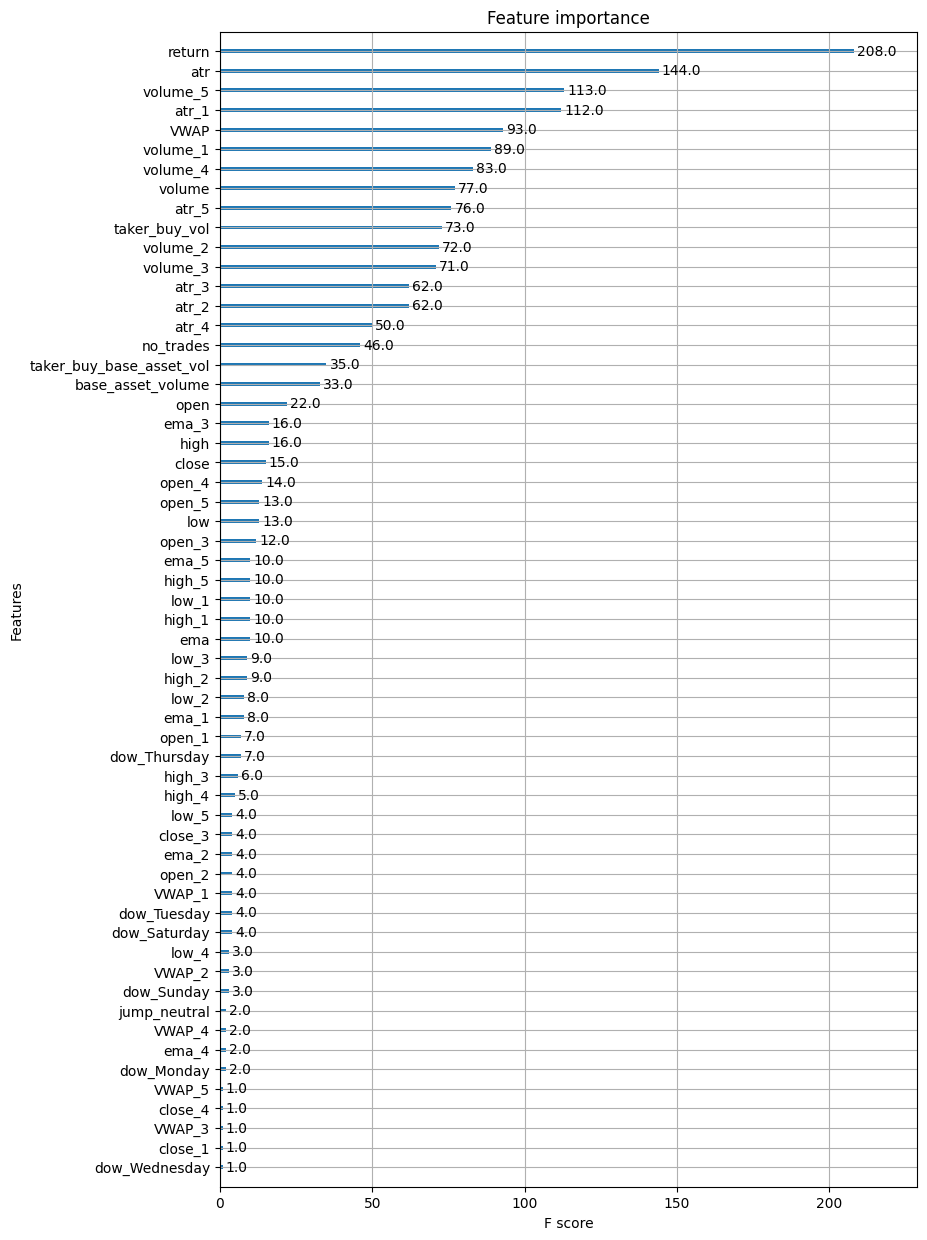

In [41]:
fig, ax = plt.subplots(figsize=(9,15))
xgb.plot_importance(model, ax=ax)
plt.show()